1.1 Particle simulations without growth
1.1.1 Unconstrained equations of motion
Consider a collection of N (t) rigid sphero-cylindrical particles with constant tip-to-tip length `n, n =
1, . . . , N , and constant cross-sectional diameter b. Because each particle will rotate and translate according
to rigid body motion, the configurational variables that dictate the system’s dynamics are each particle’s
center of mass xn(t) and orientation pn(t). To avoid the deficiencies of representing orientations using Euler
angles, we choose to represent them as unit quaternions qn(t) = [sn, wn]T (t) with scalar component sn and
vector component wn. The generalized configuration of the colony can then be written as a column vector
C(t) = [. . . , xT
n , sn, wT
n , . . .]T with 7 degrees of freedom per particle, one of which is redundant due to the
use of quaternions instead of Euler angles.
In the presence of body forces and torques {Fn, Tn}N
n=1, particles move with a translational velocity Un
and angular velocity Ωn, which can be determined using some known force-velocity relation U = MF . Here,
F = [. . . , FT
n , TT
n , . . .]T and U = [. . . , UT
n , ΩT
n , . . .]T are both column vectors with 6 degrees of freedom per
particle. The explicit form of the mobility matrix M is problem-specific and often a function of particle
properties such as position, orientation, and acceleration. In this work, we focus on inertia-less particles
sitting on a frictional substrate. For simplicity, we assume that the friction force is linearly proportional to
the velocity with friction factor ξ. Specifically, let f friction
n (s) = −ξun(s) be the frictional force density along
the rod centerline, where un is the centerline velocity and s ∈ [−`n/2, `n/2] is an arclength parameter. Since
the particles are assumed to be rigid, we have un(s) = Un + Ωn × spn. Therefore

In [1]:
import numpy as np

In [2]:
def make_particle_position(x, s, w):
    """
    Create a particle representation in 4D space.

    Parameters:
    x (array-like): Center of mass coordinates
    s (float): Scalar component
    w (array-like): Vector component

    Returns:
    np.ndarray: A 4D array representing the particle
    """
    # Ensure x and w are numpy arrays
    x = np.asarray(x, dtype=float)
    w = np.asarray(w, dtype=float)

    # Check dimensions
    if x.shape != (3,) or w.shape != (3,):
        raise ValueError("x and w must be 3D vectors")

    # Create the particle representation
    C = np.concatenate((x, [s], w))

    return C


def make_particle_length(l):
    """
    Create a particle representation with length.

    Parameters:
    l (float): Length of the particle

    Returns:
    np.ndarray: A 1D array representing the length
    """
    # Ensure l is a float
    l = float(l)

    # Create the length representation
    L = np.array([l])

    return L


def make_particle_forces(f, t):
    """
    Create a particle representation with forces.
    Parameters:
    f (array-like): Force vector
    t (array-like): Torque vector
    Returns:
    np.ndarray: A 6D array representing the forces and torques
    """
    # Ensure f and t are numpy arrays
    f = np.asarray(f, dtype=float)
    t = np.asarray(t, dtype=float)

    # Check dimensions
    if f.shape != (3,) or t.shape != (3,):
        raise ValueError("f and t must be 3D vectors")

    # Create the forces and torques representation
    F = np.concatenate((f, t))

    return F


def make_particle_velocity(v, w):
    """
    Create a particle representation with velocity.
    Parameters:
    v (array-like): Linear velocity vector
    w (array-like): Angular velocity vector
    Returns:
    np.ndarray: A 6D array representing the velocities
    """
    # Ensure v and w are numpy arrays
    v = np.asarray(v, dtype=float)
    w = np.asarray(w, dtype=float)

    # Check dimensions
    if v.shape != (3,) or w.shape != (3,):
        raise ValueError("v and w must be 3D vectors")

    # Create the velocity representation
    V = np.concatenate((v, w))

    return V

In [3]:
def calc_friction_force(F, U, L, n):
    """
    Calculate the friction force on a particle.
    Parameters:
    F (array-like): Force vector
    U (array-like): Velocity vector
    L (array-like): Length vector
    n (float): index
    Returns:
    np.ndarray: The friction force vector
    """
    Un = U[6*n:6*n + 3]
    Omegan = U[6*n + 3:6*n + 6]

    # Calculate the friction force
    XI = 1
    ln = L[n]
    Fn = -XI * ln * Un

    # Calculate the torque
    Tn = -XI * ln**3/12 * Omegan

    return Fn, Tn

In [4]:
p1 = make_particle_position([0, 0, 0], 1.0, [0, 0, 0])
p2 = make_particle_position([1, 1, 0], 1.0, [0, 0, 0])
p3 = make_particle_position([2, 2, 0], 1.0, [0, 0, 0])

l1 = make_particle_length(1.0)
l2 = make_particle_length(1.0)
l3 = make_particle_length(1.0)

f1 = make_particle_forces([1, 0, 0], [0, 0, 0])
f2 = make_particle_forces([0, 0, 0], [1, 0, 0])
f3 = make_particle_forces([0, 1, 0], [0, 0, 0])


C = np.concatenate((p1, p2, p3), axis=0)
L = np.concatenate((l1, l2, l3), axis=0)
F = np.concatenate((f1, f2, f3), axis=0)

In [5]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import numpy as np


def quaternion_to_direction(quaternion):
    """
    Convert a quaternion to a direction vector.

    Parameters:
    quaternion (array-like): 4-element quaternion [s, v1, v2, v3]

    Returns:
    numpy.ndarray: 3D unit vector representing the direction
    """
    s, v1, v2, v3 = quaternion

    # This assumes the quaternion rotates the [0, 0, 1] vector
    # to get the rod direction

    # Convert quaternion to rotation matrix
    # and apply to [0, 0, 1]

    v_norm_sq = v1**2 + v2**2 + v3**2

    if np.isclose(v_norm_sq, 0):
        # If vector part is zero, return default direction
        return np.array([0, 0, 1])

    # Normalize quaternion if needed
    norm = np.sqrt(s**2 + v_norm_sq)
    if not np.isclose(norm, 1.0):
        s, v1, v2, v3 = s/norm, v1/norm, v2/norm, v3/norm

    # Apply rotation to [0, 0, 1]
    x = 2 * (v1*v3 + s*v2)
    y = 2 * (v2*v3 - s*v1)
    z = s**2 - v1**2 - v2**2 + v3**2

    direction = np.array([x, y, z])

    # Normalize the direction vector
    return direction / np.linalg.norm(direction)


def render_particles(C, L, fig=None, ax=None, F=None):
    """
    Render the particles in 3D space.

    Parameters:
    C (array-like): Configuration of particles where each particle uses 7 values
                   (3 for position, 4 for quaternion orientation)
    L (array-like): Particle lengths
    F (array-like, optional): If provided, used for quaternion vector part
    """

    if fig is None or ax is None:
        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')

    # Set axis labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

    for i in range(len(L)):
        # Extract position (x, y, z)
        pos = C[i*7:i*7 + 3]

        # Extract quaternion components
        s = C[i*7 + 3]  # quaternion scalar part
        v = C[i*7 + 3:i*7 + 6]  # quaternion vector part

        # Get the particle length
        length = L[i]

        # Convert quaternion to direction vector
        direction = quaternion_to_direction([s, v[0], v[1], v[2]])

        # Calculate endpoints of the rod
        start_point = pos - 0.5 * length * direction
        end_point = pos + 0.5 * length * direction

        # Draw the rod
        ax.plot([start_point[0], end_point[0]],
                [start_point[1], end_point[1]],
                [start_point[2], end_point[2]],
                linewidth=2,
                marker='o',
                markersize=4,
                label=f'Particle {i}')

    # Set equal aspect ratio
    ax.set_box_aspect([1, 1, 1])

    # Add legend (only if there are a reasonable number of particles)
    if len(L) <= 10:
        ax.legend()

    # Show the plot
    plt.title("3D Particle Visualization")
    plt.tight_layout()

    return fig, ax

In [6]:
def make_particle_mobility_matrix(L, i):
    """
    Create a mobility matrix for n particles.
    Parameters:
    L (array-like): Length vector
    i (int): Index of the particle
    Returns:
    np.ndarray: The mobility matrix
    """
    # Create the mobility matrix
    M = np.zeros((6, 6))

    M[0:3, 0:3] = np.eye(3) * L[i]
    M[3:6, 3:6] = np.eye(3) * 12 / (L[i]**3)

    return M

In [7]:
from scipy.linalg import block_diag

M = block_diag(*[make_particle_mobility_matrix(L, i) for i in range(len(L))])

In [8]:
U = M @ F

In [9]:
# calc_friction_force(F, U, L, 0)

In [10]:
def make_map(C):

    def Xi(n):
        sn = C[6*n + 3:6*n + 4]
        wn = C[6*n + 4:6*n + 7]

        def W(n): return np.array(
            [[0, -wn[2], wn[1]], [wn[2], 0, -wn[0]], [-wn[1], wn[0], 0]])

        return 0.5 * np.block([[-wn.T], [sn*np.eye(3) - W(n)]])

    def Gn(n):
        return block_diag(*[np.eye(3), Xi(n)])

    return block_diag(*[Gn(n) for n in range(len(C)//6)])

In [11]:
G = make_map(C)

In [12]:
Cdot = G @ U

In [13]:
GeneralizedMobilityMatrix = G @ M @ G.T

In [14]:
def update_C(C, M, F, G, dt):
    """
    Update the particle positions and velocities.
    Parameters:
    C (array-like): Current particle representation
    G (array-like): Generalized mobility matrix
    U (array-like): Velocity vector
    dt (float): Time step
    Returns:
    np.ndarray: Updated particle representation
    """
    # Ensure C, G, and U are numpy arrays
    C = np.asarray(C, dtype=float)
    M = np.asarray(M, dtype=float)
    F = np.asarray(F, dtype=float)
    G = np.asarray(G, dtype=float)

    U = M @ F
    Cdot = G @ U

    # Update the particle representation
    C_new = C + dt * Cdot
    return C_new

In [15]:
C

array([0., 0., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 0., 0., 2., 2., 0.,
       1., 0., 0., 0.])

In [16]:
C_new = update_C(C, M, F, G, 0.1)

(<Figure size 1000x800 with 1 Axes>,
 <Axes3D: title={'center': '3D Particle Visualization'}, xlabel='X', ylabel='Y', zlabel='Z'>)

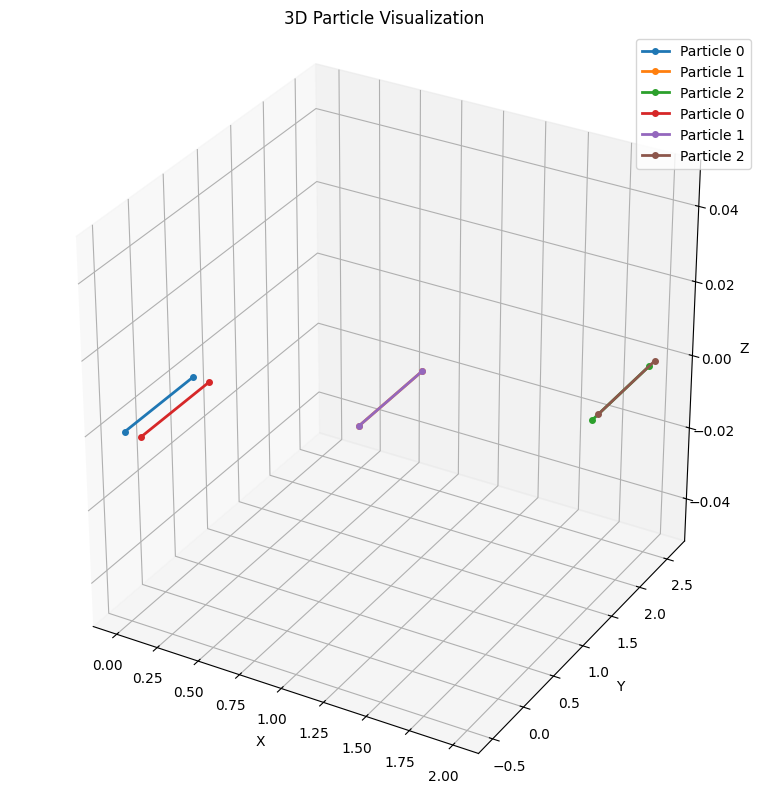

In [17]:
# Render the particles
fig, ax = render_particles(C, L)
render_particles(C_new, L, fig, ax)

In [18]:
def signed_seperation_points(y, alpha, n, m):
    yn = y[n][alpha]
    ym = y[m][alpha]

    # Calculate the signed separation
    distance = np.linalg.norm(yn - ym)
    signed_distance = distance * \
        np.sign(np.dot(yn - ym, y[n][alpha] - y[m][alpha]))
    return signed_distance


def signed_distance_capsule(C, L, n, m):
    x1 = C[7*n:7*n + 3]  # position of capsule
    s1 = C[7*n + 3:7*n + 4]  # scalar of quaternion
    w1 = C[7*n + 4:7*n + 7]  # vector of quaternion

    x2 = C[7*m:7*m + 3]  # position of capsule
    s2 = C[7*m + 3:7*m + 4]  # scalar of quaternion
    w2 = C[7*m + 4:7*m + 7]  # vector of quaternion

    # P0 and P1 are the endpoints of the capsule
    dir1 = quaternion_to_direction([s1, w1[0], w1[1], w1[2]])
    dir2 = quaternion_to_direction([s2, w2[0], w2[1], w2[2]])

    # TODO: Radius of the capsule?
    P0 = x1 - (L[n] / 2) * dir1
    P1 = x1 + (L[n] / 2) * dir1

    Q0 = x2 - (L[m] / 2) * dir2
    Q1 = x2 + (L[m] / 2) * dir2

    def R(s, t):
        p = np.array([s*t])
        M = np.array([[np.dot(P1-P0, P1-P0), -np.dot(P1-P0, Q1-Q0)],
                      [-np.dot(P1-P0, Q1-Q0), np.dot(Q1-Q0, Q1-Q0)]])

        K = np.array([(np.dot(P1-P0, P0-Q0)), (np.dot(Q1-Q0, P0-Q0))])

        f = np.dot(P0-Q0, P0-Q0)

        return p@M@p + 2*K@p + f

    # constrained conjugate gradient approach

    def f(s, t):
        p = np.array([s, t])
        M = np.array([[np.dot(P1-P0, P1-P0), -np.dot(P1-P0, Q1-Q0)],
                      [-np.dot(P1-P0, Q1-Q0), np.dot(Q1-Q0, Q1-Q0)]])

        K = np.array([(np.dot(P1-P0, P0-Q0)), (np.dot(Q1-Q0, P0-Q0))])

        f = np.dot(P0-Q0, P0-Q0)

        return p@M@p + 2*K@p + f

    def f_prime(s, t):
        p = np.array([s, t])
        M = np.array([[np.dot(P1-P0, P1-P0), -np.dot(P1-P0, Q1-Q0)],
                      [-np.dot(P1-P0, Q1-Q0), np.dot(Q1-Q0, Q1-Q0)]])

        K = np.array([(np.dot(P1-P0, P0-Q0)), (np.dot(Q1-Q0, P0-Q0))])

        f = np.dot(P0-Q0, P0-Q0)

        return 2*M@p + 2*K

    # Initial guess
    s0 = 0.5
    t0 = 0.5

    # Gradient descent
    alpha = 0.01
    for _ in range(100):
        grad = f_prime(s0, t0)
        s0 -= alpha * grad[0]
        t0 -= alpha * grad[1]
        if np.linalg.norm(grad) < 1e-6:
            break

    # Calculate intersection point
    s = s0
    t = t0

    P = P0 + s * (P1 - P0)
    Q = Q0 + t * (Q1 - Q0)

    # radius

    normal = (P - Q) / np.linalg.norm(P - Q)

    # points at surface where collision occurs
    radius = 1  # TODO
    P_surface = P + normal * radius
    Q_surface = Q - normal * radius

    # Calculate the signed distance
    signed_distance = np.linalg.norm(P_surface - Q_surface)
    return signed_distance, P_surface, Q_surface, normal

In [19]:
deltaT = 1


def g_fun(gamma):

    # find argmin gamma >=0

    def y_dot(P, n):
        # caluclate speed of poiint P on rod n
        x = C[7*n:7*n + 3]

        v_linear = U[6*n:6*n + 3]
        w_angular = U[6*n + 3:6*n + 6]

        # Calculate the velocity of point P
        v_point = v_linear + np.cross(w_angular, P - x)
        return v_point

    def calc_distances():
        phi = []
        phi_dot = []
        for n in range(len(C)//7):
            for m in range(n+1, len(C)//7):
                # todo n should be surface normal

                s, yN, yM, norm = signed_distance_capsule(C, L, n, m)

                phi.append(s)

                phi_dot_alpha = np.dot(y_dot(yN, n), norm) + \
                    np.dot(y_dot(yM, n), norm)
                phi_dot.append(phi_dot_alpha)

        return np.array(phi), np.array(phi_dot)

    phi, phi_dot = calc_distances()

    return phi+deltaT * phi_dot


def residual(gamma):
    def projectedGradientDescent(X, gamma):
        X[gamma > 0] = np.minimum(0, X[gamma > 0])
        X[gamma <= 0] = np.maximum(0, X[gamma <= 0])
        return X

    return np.linalg.norm(projectedGradientDescent(g_fun(gamma), gamma), ord=np.inf)


def barzilaiBorweinProjectedGradientDescent(steps=100, eps=1e-6):
    gamma = np.zeros((len(C)//7 * (len(C)//7 - 1))//2)
    g = g_fun(gamma)
    res = residual(gamma)
    alpha = 1/res

    for i in range(steps):
        gamma_old = gamma
        gamma = np.maximum(gamma - alpha * g, 0)
        g_old = g
        g = g_fun(gamma)
        res = residual(gamma)
        if res < eps:
            break
        alpha = (gamma - gamma_old).T @ (gamma - gamma_old) / \
            ((gamma - gamma_old).T @ (g - g_old))
        if np.isnan(alpha) or alpha < 0:
            alpha = 0.1

    return gamma


gamma = barzilaiBorweinProjectedGradientDescent()
print("Gamma:", gamma)

Gamma: [0. 0. 0.]


/tmp/ipykernel_4647/4052256356.py:64: RuntimeWarning: invalid value encountered in scalar divide
  alpha = (gamma - gamma_old).T @ (gamma - gamma_old) / \


In [20]:

def calc_collision_forces(gamma):

    F = np.array([], dtype=float)
    T = np.array([], dtype=float)

    phi = []
    for n in range(len(C)//7):
        for m in range(n+1, len(C)//7):
            # todo n should be surface normal

            s, yN, yM, norm = signed_distance_capsule(C, L, n, m)
            phi.append(s)

            f = gamma[n] * norm

            t = np.cross(yN, norm * gamma[n])

            F = np.concatenate((F, f))
            T = np.concatenate((T, t))

    return F, T

In [21]:
calc_collision_forces(gamma)

(array([-0., -0.,  0., -0., -0.,  0., -0., -0.,  0.]),
 array([ 0.,  0.,  0.,  0.,  0.,  0.,  0., -0.,  0.]))